In [2]:
pip install tqdm numpy matplotlib torch tensorboard tensorboardx

Note: you may need to restart the kernel to use updated packages.


# Traveling salesman

The pyqubo interface isn't the most user friendly when complicated calculations are
needed. The numpy interface is preferred where linear algebra can be done easily and
succinctly. Let's try to implement the simulated annealing process for the traveling
salesman in pytorch.

In [1]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

from sa import BitSampler, SimulatedAnnealing
from utils import plot_graph

In [2]:
%load_ext tensorboard

We won't be using gradients at all. To avoid keeping track of operations we'll drop
all gradients

In [3]:
torch.no_grad()

# Graph

Define the graph and the vertices. The number of vertices is equal to the number of binary variables we need to initialise in the array.

(<Figure size 600x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbd968ad130>)

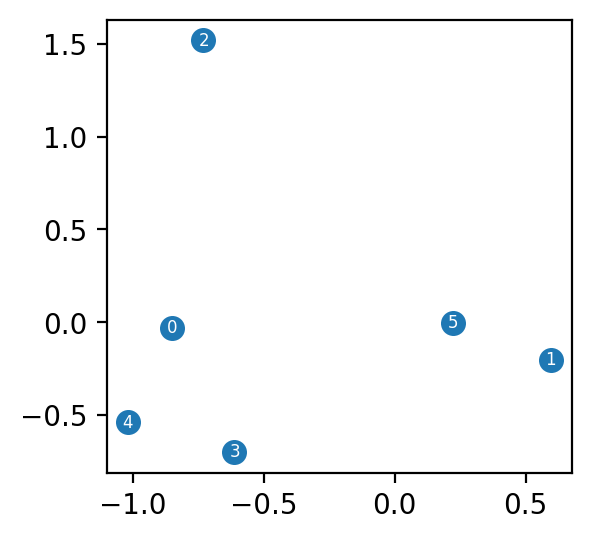

In [4]:
#graph = torch.randn((6, 2), dtype=torch.float)
graph = torch.tensor([
    [-0.8494, -0.0292],
    [ 0.5966, -0.2025],
    [-0.7303,  1.5206],
    [-0.6110, -0.6992],
    [-1.0172, -0.5384],
    [ 0.2233, -0.0027],
])
plot_graph(graph.detach())

In [5]:
graph

tensor([[-0.8494, -0.0292],
        [ 0.5966, -0.2025],
        [-0.7303,  1.5206],
        [-0.6110, -0.6992],
        [-1.0172, -0.5384],
        [ 0.2233, -0.0027]])

## Model

The `nn.Module` class which typically defines our model will define the hamiltonian
for this problem

In [6]:
class TSPHamiltonian(nn.Module):
    """Hamiltonian for the Traveling Salesman Problem (TSP)"""
    def __init__(self, nvert, k=1.):
        super().__init__()
        
        self.cycle = nn.Parameter(
            torch.randint(0, 2, (nvert, nvert), dtype=torch.bool),
            requires_grad=False,
        )
        self.k = nn.Parameter(torch.tensor(k), requires_grad=False)
        
    def simultaneous_constraint(self):
        return ((self.cycle.sum(axis=1)-1)**2).sum()
    
    def visits_constraint(self):
        return ((self.cycle.sum(axis=0)-1)**2).sum()
    
    def distance(self, x):
        cfloat = self.cycle.type(torch.float)
        return torch.einsum(
            'ij, ki, kj -> ',
            torch.cdist(x, x), cfloat[:-1,:],
            torch.roll(cfloat, -1, dims=0)[:-1,:],
        )
        
    def forward(self, x):
        return (
            self.distance(x) + self.k*(
                self.simultaneous_constraint()
                + self.visits_constraint()
            )
        )

A sampler class will randomly generate a bit flip in `self.cycle`. An optimizer will
take care of the simulated annealing with the learning rate representing the
temperature which decays by a scheduler.

PyQUBO by default runs 1000 steps at the same lr, with a linearly decreasing log(lr)
between 1 and 1/50 in 10 intervals. This is equivalent to a scheduler with 1000 steps
and a gamma factor of $(1/50)^{1/9}$. This will require a total of 10k steps.

In [8]:
(1/50)**(1/9)

0.6474788028695254

In [9]:
model = TSPHamiltonian(graph.shape[0], k=4.)

In [10]:
sampler = BitSampler()
optimizer = SimulatedAnnealing((model.cycle,), sampler=sampler, lr=1.)
scheduler = StepLR(optimizer, 1000, gamma=0.65)

In [11]:
!rm -rf runs

In [12]:
writer = SummaryWriter()

for epoch in tqdm(range(10000)):
    loss = optimizer.step(lambda: model(graph))
    scheduler.step()
    writer.add_scalar('loss', loss.item(), epoch)
    writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)
    
writer.flush()

In [13]:
%tensorboard --logdir runs/

Reusing TensorBoard on port 6007 (pid 46439), started 14:37:09 ago. (Use '!kill 46439' to kill it.)

In [14]:
nbroken = (
    torch.tensor(model.cycle.shape).sum()
    - (
        (model.cycle.sum(axis=0)==1).sum()
        + (model.cycle.sum(axis=1)==1).sum()
    )
)
print(f'Number of broken constraints: {nbroken.item()}')
print(f'Energy: {model(graph):.3f}')

Number of broken constraints: 0
Energy: 6.525


(<Figure size 600x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbd96821370>)

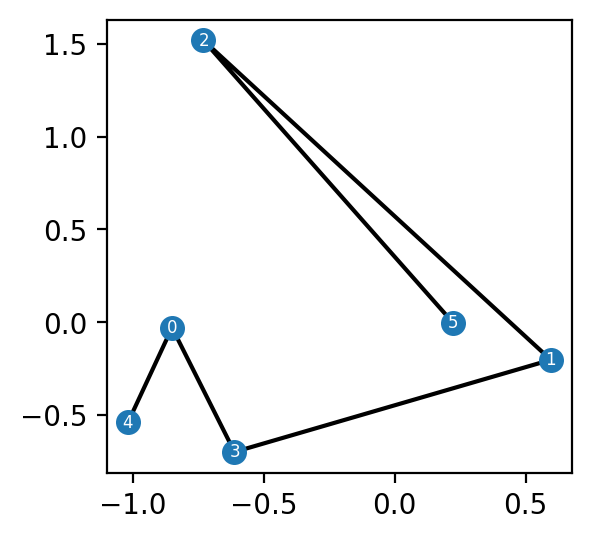

In [15]:
edges = np.where(model.cycle.data)[1]
plot_graph(graph, edges=edges)

Doesn't quite work exactly how pyqubo does, but it's a nice proof of principle.